# Confidence analysis

#### Confronto tra la confidence di OpenFace e il *concordance correlation coefficient* tra i landmark dei due tool.

In [36]:
%matplotlib inline

import os
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from scipy.signal import find_peaks, peak_widths
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing

In [26]:
FACE_MESH = pd.read_csv('faceMesh/face_mesh.csv')

def landmarks_mapper(video: str, cleansed_data: bool):
    
    OPENFACE_LANDMARKS = [i for i in range(17, 68)]
    
    if cleansed_data:
        OPENFACE_DIR = 'openFace/processed_cleansed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed_cleansed/'
    else:
        OPENFACE_DIR = 'openFace/processed/'
        MEDIAPIPE_DIR = 'mediaPipe/processed/'
        
    of_df = pd.read_csv(OPENFACE_DIR + video + '_openface.csv')
    mp_df = pd.read_csv(MEDIAPIPE_DIR + video + '_mediapipe.csv')
    
    final_df = of_df['frame'] # initialize the final dataframe
    for i, landmark in enumerate(OPENFACE_LANDMARKS):

        mask = (FACE_MESH['openFace_landmark'] == landmark) # group the mediapipe landmarks by the openface landmark

        tmp1_df = of_df[[f'x_{landmark}', f'y_{landmark}']] # select the columns from the openface dataframe
        tmp1_df.columns = [f'openface_x_{landmark}', f'openface_y_{landmark}'] # rename the columnsk
        
        mediaPipe_landmarks_X = ['x_'+str(ID) for ID in FACE_MESH[mask].id] # collect the X coordinate
        mediaPipe_landmarks_Y = ['y_'+str(ID) for ID in FACE_MESH[mask].id] # collect the Y coordinate
        
        tmp2_df = pd.DataFrame({f'mediapipe_x_{landmark}':mp_df[mediaPipe_landmarks_X].mean(axis=1),
                                f'mediapipe_y_{landmark}':mp_df[mediaPipe_landmarks_Y].mean(axis=1)})
        
        final_df = pd.concat([final_df, tmp1_df, tmp2_df], axis=1)
        
    return final_df

In [27]:
def windowize(df: pd.DataFrame, window_size: float):
    """
    Returns an array of dataframes of the windowized video
    """
    LANDMARKS = [f'x_{i}' for i in range(68)] + [f'y_{i}' for i in range(68)]
    n_frames = round(window_size*24) # 24 frames per second
    n_dataFrames = df.frame.size-n_frames+1
    array_df = np.ndarray(shape=n_dataFrames, dtype=pd.DataFrame)
    for i in range(n_dataFrames):
        array_df[i] = df.iloc[i:i+n_frames]
    
    return array_df

In [28]:
def pearson(df: pd.DataFrame):
    
    lndmk_pearson = []
    for i in range(17, 68):
        
        x_pearson = pearsonr(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())[0]
        y_pearson = pearsonr(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())[0]
        lndmk_pearson.append((x_pearson+y_pearson)/2)
    
    video_pearson = np.mean(lndmk_pearson)
    
    return video_pearson

In [29]:
def mse(df: pd.DataFrame):
    
    lndmk_mse = []
    for i in range(17, 68):
        
        x_mse = mean_squared_error(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_mse = mean_squared_error(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_mse.append((x_mse+y_mse)/2)
    
    video_mse = np.mean(lndmk_mse)
    
    return video_mse

In [30]:
def r2(df: pd.DataFrame):
    
    lndmk_r2 = []
    for i in range(17, 68):
        
        x_r2 = r2_score(df[f'mediapipe_x_{i}'].to_numpy(), df[f'openface_x_{i}'].to_numpy())
        y_r2 = r2_score(df[f'mediapipe_y_{i}'].to_numpy(), df[f'openface_y_{i}'].to_numpy())
        lndmk_r2.append((x_r2+y_r2)/2)
    
    video_r2 = np.mean(lndmk_r2)
    
    return video_r2

In [31]:
def rhoc(x,y):

    sxy = np.sum((x - x.mean())*(y - y.mean()))/x.shape[0]
    rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
    
    return rhoc

In [9]:
def ccc(df: pd.DataFrame):
    
    lndmk_ccc = []
    for i in range(17,68):
        
        x_ccc = rhoc(df[f'openface_x_{i}'].to_numpy(), df[f'mediapipe_x_{i}'].to_numpy())
        y_ccc = rhoc(df[f'openface_y_{i}'].to_numpy(), df[f'mediapipe_y_{i}'].to_numpy())
        lndmk_ccc.append((x_ccc+y_ccc)/2)
        
    video_ccc = np.mean(lndmk_ccc)
    
    return video_ccc

In [9]:
#confidence_analysis_dfs_array = np.ndarray(shape=615, dtype=pd.DataFrame)
for i,video in enumerate(os.listdir('dataset/ElderReact_Data/ElderReact_train/')):
    
    videoName = video[:-4]
    openFace_df = pd.read_csv(f'openFace/processed_cleansed/{videoName}_openface.csv')
    
    landmarks_df = landmarks_mapper(videoName, cleansed_data=True)
    ccc_per_window = [ccc(window) for window in windowize(landmarks_df, 0.5)]
    n_frames = len(ccc_per_window)
#    confidence_analysis_dfs_array[i] = pd.DataFrame({'frame': [frame for frame in range(1, n_frames+1)], 'openface_cf': openFace_df.confidence.iloc[:n_frames], 'ccc': ccc_per_window})
#    pd.DataFrame({'frame': [frame for frame in range(1, n_frames+1)], 'openface_cf': openFace_df.confidence.iloc[:n_frames], 'ccc': ccc_per_window}).to_csv(f'openFace/confidence_ccc/{videoName}_cfccc.csv')

<ipython-input-5-0177c87c4cec>:4: RuntimeWarning: invalid value encountered in double_scalars
  rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
<ipython-input-5-0177c87c4cec>:4: RuntimeWarning: invalid value encountered in double_scalars
  rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)
<ipython-input-5-0177c87c4cec>:4: RuntimeWarning: invalid value encountered in double_scalars
  rhoc = 2*sxy / (np.var(x) + np.var(y) + (x.mean() - y.mean())**2)


In [ ]:
%store confidence_analysis_dfs_array

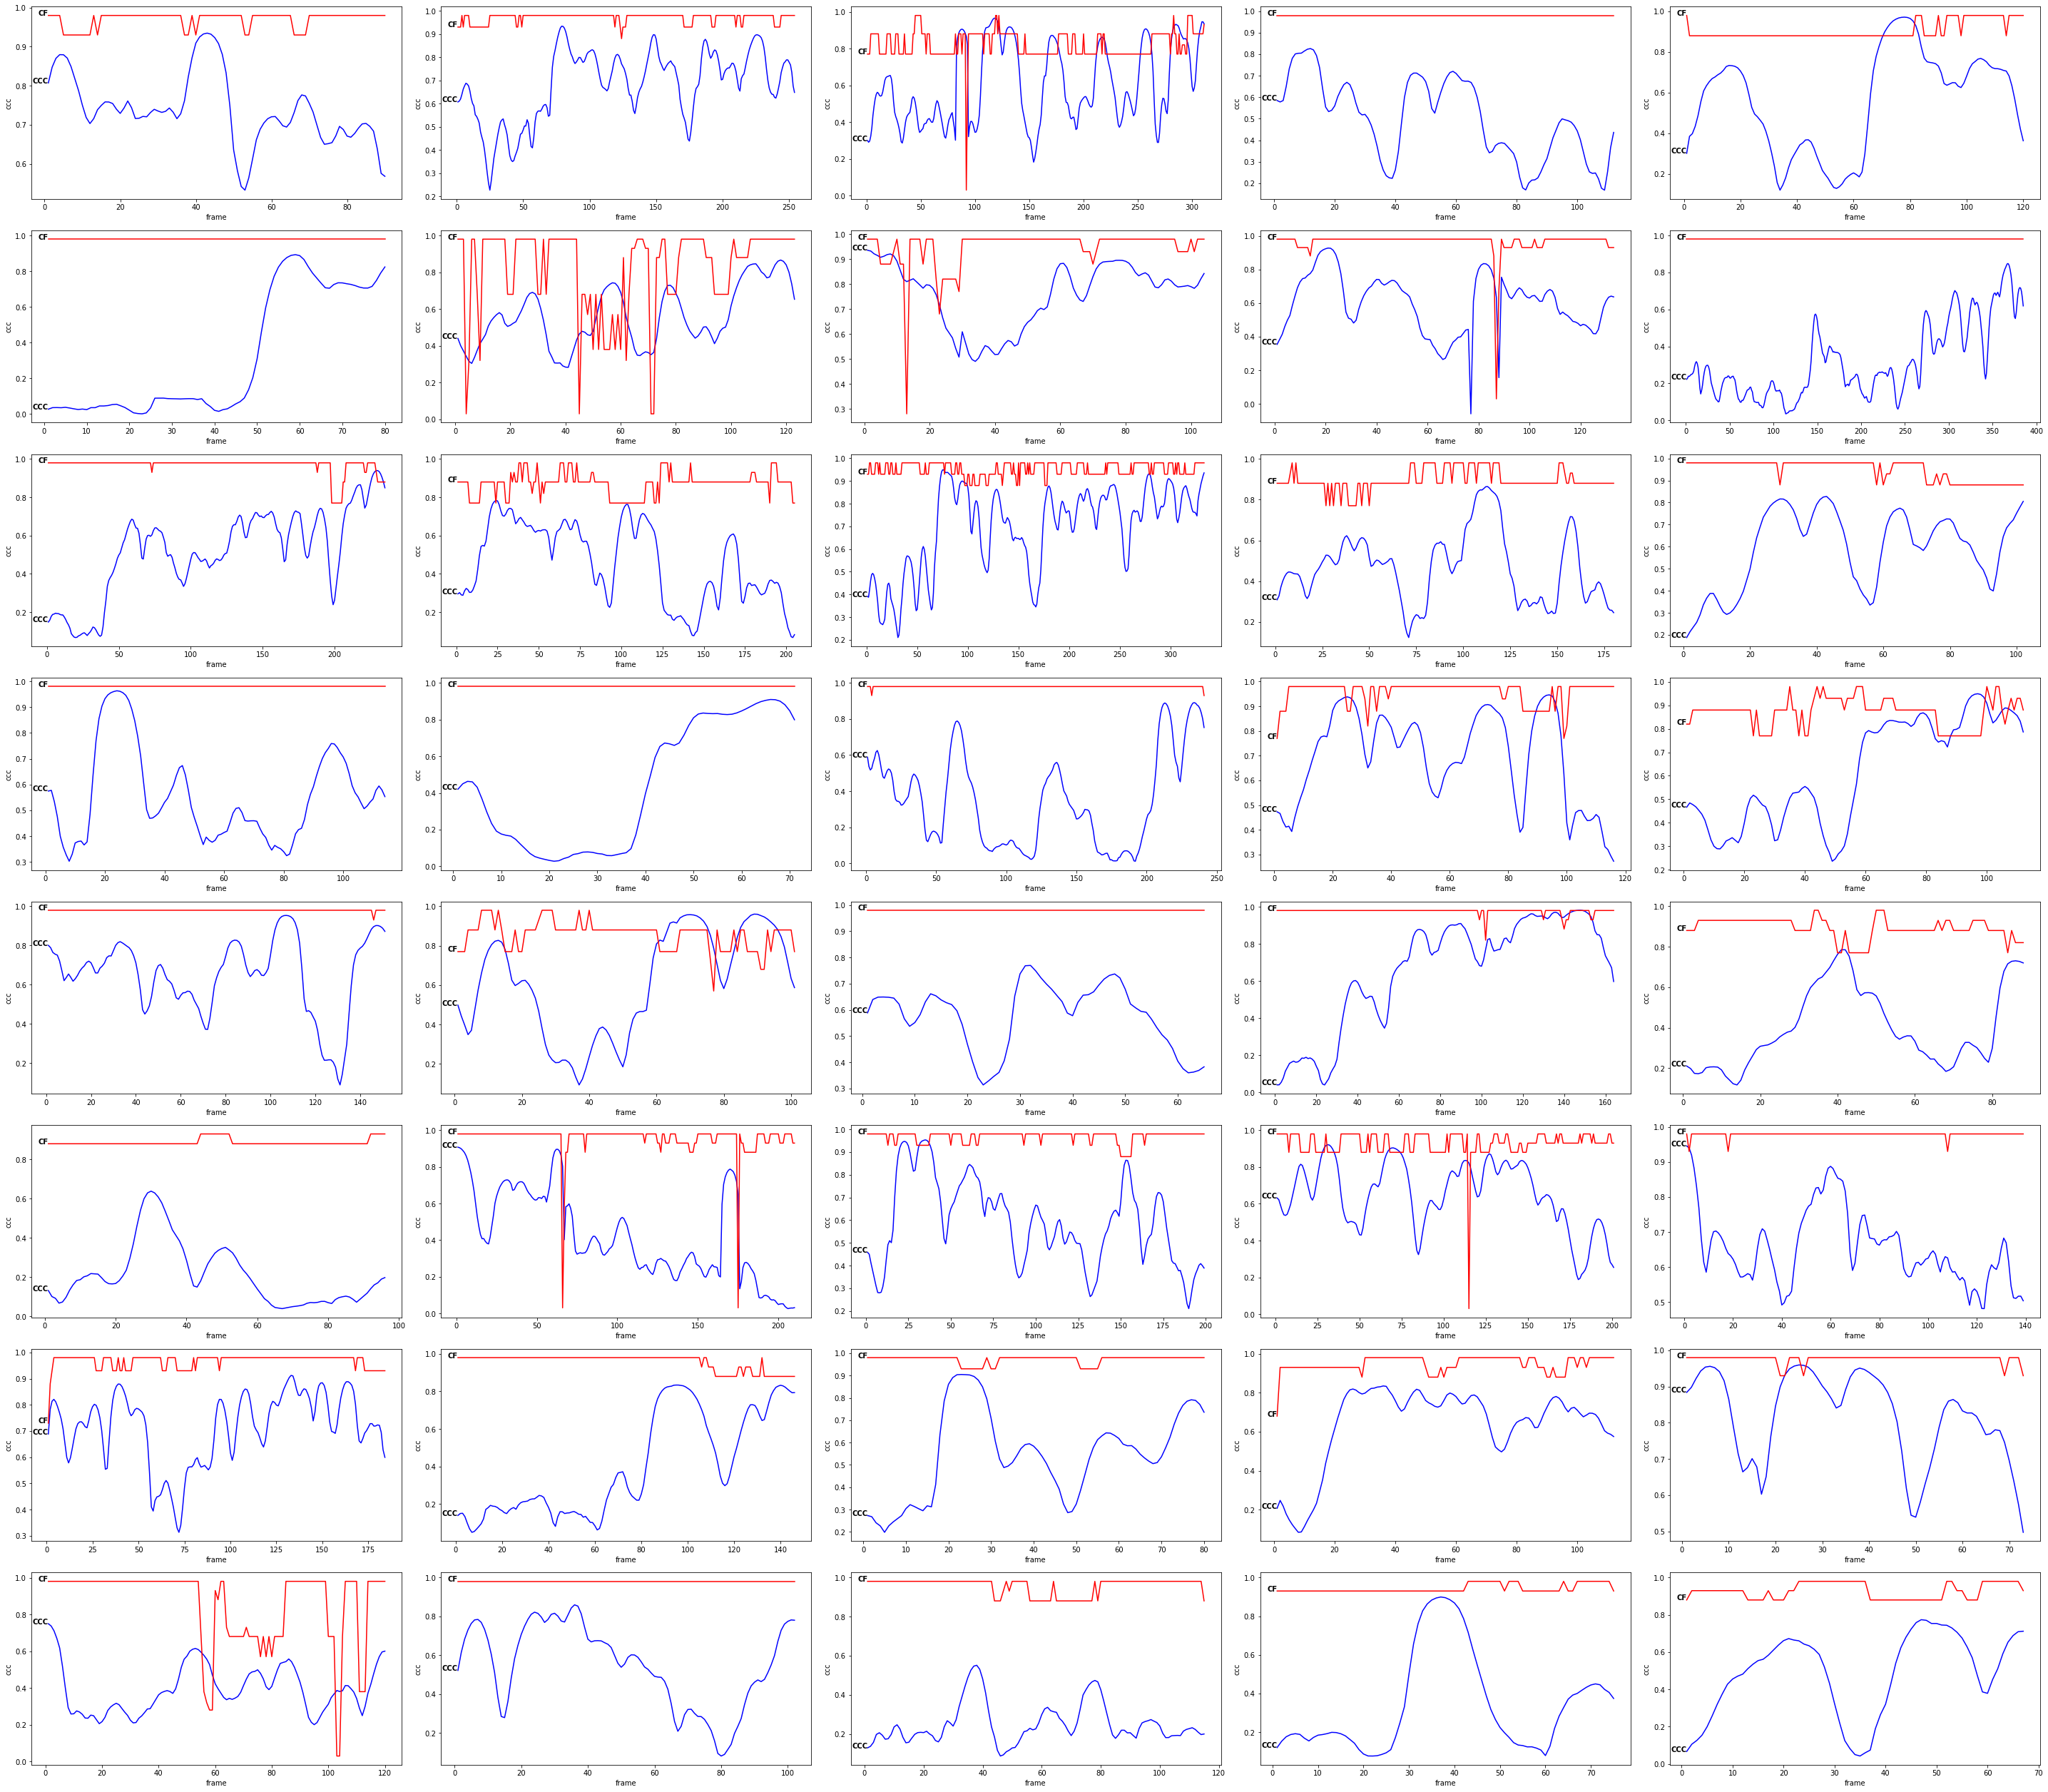

In [55]:
openFace_nose_lndmks = [i for i in range(27, 36)]

fig, axes = plt.subplots(8, 5, figsize=(40, 35))
axes = axes.flatten()

for i, df in enumerate(confidence_analysis_dfs_array[:-15:15]):
    
    sns.lineplot(data=df, x='frame', y='ccc', ax=axes[i], color='blue')
    sns.lineplot(data=df, x='frame', y='openface_cf', ax=axes[i], color='red')
    
    axes[i].text(df['frame'][0], df['ccc'][0], "CCC", horizontalalignment='right', size='medium', color='black', weight='semibold')
    axes[i].text(df['frame'][0], df['openface_cf'][0], "CF", horizontalalignment='right', size='medium', color='black', weight='semibold')
    
plt.tight_layout()
plt.show()

Dai grafici sembra che non vi sia una correlazione tra la confidence il ccc, anche se l'andamento di quest'ultimo è molto influenzato dalla dimensione della finestra scorrevole, la quale, più è piccola, peggiore è l'andamento del ccc, viceversa più è grande migliore è l'andamento)

/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/home/filippo/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRC

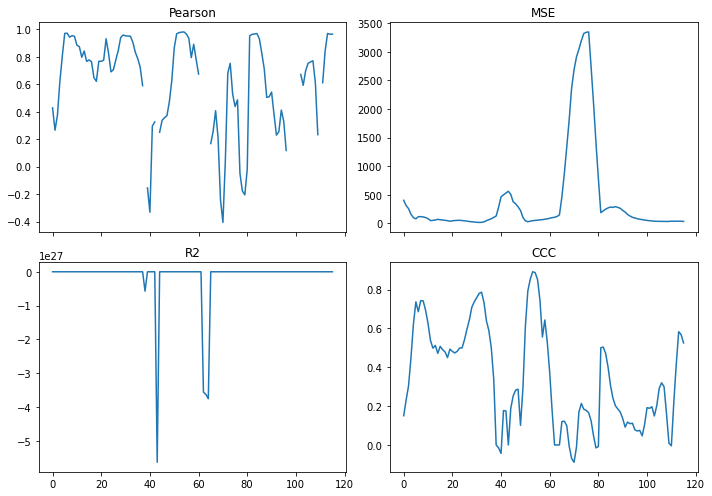

In [37]:
video_name = '50_50_4'
window_size_in_seconds = 0.2
window_size = round(window_size_in_seconds*24)
mapped_landmarks_df = landmarks_mapper(video_name, cleansed_data=True)
windows = mapped_landmarks_df.rolling(window=window_size, center=True)
    
landmarks_df = pd.read_csv(f'dataframes/landmarks/{video_name}_landmarks.csv')
openface_landmarks = [f'x_{landmark_id}_openface' for landmark_id in range(17,68)]
mediapipe_landmarks = [f'x_{landmark_id}_mediapipe' for landmark_id in range(17,68)]

windowized_features = np.asarray([np.array([pearson(window), mse(window), r2(window), ccc(window)]) for window in windows])
windowized_pearson, windowized_mse, windowized_r2, windowized_ccc = windowized_features[:,0], windowized_features[:,1], windowized_features[:,2], windowized_features[:,3]
features=[windowized_pearson, windowized_mse, windowized_r2, windowized_ccc]

titles=['Pearson', 'MSE', 'R2', 'CCC']
fig, axes = plt.subplots(2,2, sharex=True, figsize=(10,7))
    
axes[0][0].plot(features[0])
axes[0][0].set_title(titles[0])

axes[0][1].plot(features[1])
axes[0][1].set_title(titles[1])

axes[1][0].plot(features[2])
axes[1][0].set_title(titles[2])

axes[1][1].plot(features[3])
axes[1][1].set_title(titles[3])
        
plt.tight_layout()
plt.show()

In [12]:
video_name = '50_50_4'
window_size = (lambda seconds: round(24*seconds))(0.2)
mapped_landmarks_df = landmarks_mapper(video_name, cleansed_data=True)
windows = mapped_landmarks_df.rolling(window=window_size, center=True)
windowized_mse = preprocessing.normalize([[mse(window) for window in windows]], norm='max').flatten()

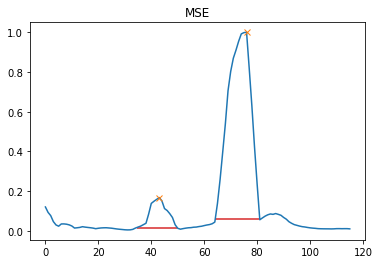

In [23]:
plt.plot(win_mse)
plt.title('MSE')

peaks, _ = find_peaks(windowized_mse, height=0.15)
widths = peak_widths(windowized_mse, peaks, rel_height=0.95)

plt.plot(peaks, windowized_mse[peaks], 'x')
plt.hlines(*widths[1:], color="C3")

plt.show()